In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
torch.manual_seed(69)

In [2]:
# desired width of image after cropping
width = 28
train_data = datasets.MNIST('./data', train=True, transform=transforms.ToTensor(), download=True)
validation_data = datasets.MNIST('./data', train=False, transform=transforms.ToTensor(), download=True)

n_train = len(train_data)
n_validation = len(validation_data)
print(f'Training data has {n_train} data points.')
print(f'Validation data has {n_validation} data points.')
print(f'Training data has dimensions {train_data[0][0].size()}')
print(f'Validation data has dimensions {validation_data[0][0].size()}')

Training data has 60000 data points.
Validation data has 10000 data points.
Training data has dimensions torch.Size([1, 28, 28])
Validation data has dimensions torch.Size([1, 28, 28])


In [0]:
def display_image(image):
  if isinstance(image, tuple):
    plt.imshow(image[0].view(width, width).numpy(), cmap='gray')
    plt.title(f'Number {image[1]}')

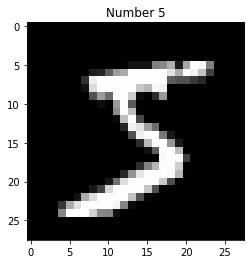

In [4]:
# Test display_image()
display_image(train_data[0])

In [0]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5, stride=1, padding=2)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.dropout1 = nn.Dropout2d(p=0.3)
    self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, stride=1, padding=2)
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.flat = nn.Flatten()
    self.linear1 = nn.Linear(in_features=784, out_features=128)
    self.dropout2 = nn.Dropout(p=0.4)
    self.linear2 = nn.Linear(in_features=128, out_features=10)
  
  def forward(self, x):
    out = F.relu(self.conv1(x))
    out = self.dropout1(self.pool1(out))
    out = F.relu(self.conv2(out))
    out = self.pool2(out)
    out = self.flat(out)
    out = F.relu(self.linear1(out))
    out = self.linear2(self.dropout2(out))
    return out
  
  def accuracy_score(self, data):
    data_size = len(data)
    data_loader = DataLoader(dataset=data, batch_size=data_size)

    accurate_predictions = 0
    for net_input, expected_output in data_loader:
      pred = torch.argmax(self.forward(net_input), 1)
      accurate_predictions += torch.sum(pred == expected_output).item()
    return accurate_predictions / data_size

In [0]:
def train_model(training_data, model, optimizer, criterion, batch_size=100, epochs=20, validation_data=None):
  """
  :arg training_data: torch.utils.data.DataLoader
  :arg model: nn.Module subclass
  :arg optimizer: nn.optim
  :arg criterion: loss function handle
  :kwarg batch_size: size of training batch
  :kwarg epochs: number of training epochs
  :kwarg validation_data: torch.utils.data.DataLoader
  """
  training_data_loader = DataLoader(dataset=training_data, batch_size=batch_size)
  accuracy = {
      'train': [],
      'validation': []
  }

  for epoch in range(epochs):

    model.train()

    for net_input, expected_output in training_data_loader:
      # reset gradient
      optimizer.zero_grad()
      # make prediction
      pred = model(net_input)
      # calculate loss
      loss = criterion(pred, expected_output)
      # backpropagate
      loss.backward()
      # update parameters
      optimizer.step()
    
    model.eval()
    
    # obtain accuracy score
    train_accuracy = model.accuracy_score(training_data)
    accuracy['train'].append(train_accuracy)
    if validation_data:
      validation_accuracy = model.accuracy_score(validation_data)
      accuracy['validation'].append(validation_accuracy)
    
    message = f'Epoch {epoch} completed -- Train accuracy {train_accuracy :.4f}'
    if validation_data:
      message += f' -- CV accuracy {validation_accuracy :.4f}'
    print(message)

  return accuracy

In [0]:
# training parameters
learning_rate = 0.01
epochs = 10
batch_size = 500

# training utilities
cnn = CNN()
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [8]:
# start training the model
accuracy = train_model(train_data, cnn, optimizer, criterion, batch_size, epochs, validation_data)

Epoch 0 completed -- Train accuracy 0.9750 -- CV accuracy 0.9765
Epoch 1 completed -- Train accuracy 0.9825 -- CV accuracy 0.9824
Epoch 2 completed -- Train accuracy 0.9872 -- CV accuracy 0.9866
Epoch 3 completed -- Train accuracy 0.9875 -- CV accuracy 0.9862
Epoch 4 completed -- Train accuracy 0.9916 -- CV accuracy 0.9860
Epoch 5 completed -- Train accuracy 0.9909 -- CV accuracy 0.9867
Epoch 6 completed -- Train accuracy 0.9916 -- CV accuracy 0.9880
Epoch 7 completed -- Train accuracy 0.9929 -- CV accuracy 0.9882
Epoch 8 completed -- Train accuracy 0.9925 -- CV accuracy 0.9874
Epoch 9 completed -- Train accuracy 0.9935 -- CV accuracy 0.9886


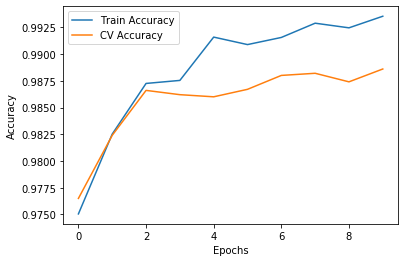

In [10]:
# plot the accuracy
plt.plot(accuracy['train'], label='Train Accuracy')
if accuracy['validation']:
  plt.plot(accuracy['validation'], label='CV Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()